# ТЕМА 3. КОГНИТИВНЫЕ ПОДХОДЫ, СИСТЕМЫ И СЕРВИСЫ В ЦИФРОВОМ БИЗНЕСЕ

В рамках данной лабораторной работы рассматривается практическое применение когнитивных подходов (в данном случае методов машинного зрения) на примере анализа и обработки изображений с помощью предобученной нейронной сети VGG16. Будет показано, как можно извлечь признаки из изображений, проанализировать их сходство и затем использовать полученные данные для улучшения пользовательского опыта и эффективности рекомендательных систем.



**Задания**:

**Изучение архитектуры и работы сверточных нейронных сетей (CNN)**:

***1)Ознакомьтесь с архитектурой и работой сверточных нейронных сетей, используя фреймворк PyTorch***.

Для этого используйте файл CNN_convnet_pytorch.ipynb.

Проанализируйте основные компоненты и слои CNN: свёрточные слои, пулинговые слои и полносвязные слои, а также их роль в обработке и классификации изображений.

Классификация изображений с использованием CNN:

***2)Решите задачи классификации изображений на наборах данных MNIST и CIFAR с использованием сверточных нейронных сетей***.

Проведите серию экспериментов, изменяя гиперпараметры модели (например, количество слоев, размер фильтров, скорость обучения и т.д.) для улучшения качества классификации.

Документируйте и проанализируйте полученные результаты, сравнив их с базовыми показателями.

## Подготовка среды и данных

In [ ]:
import os

from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from keras.applications import vgg16
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity

Подключаем Google Drive к окружению Google Colab, что позволит получить доступ к файлам, хранящимся в Google Drive, непосредственно из среды выполнения Colab.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Классификация изображений c использованием Сверточной нейронной сети на датасете MNIST

In [ ]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях trainloader.dataset.train_data и testloader.dataset.test_data:

In [ ]:
trainloader.dataset.train_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [ ]:
testloader.dataset.test_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем матрицу первой картинки:

In [ ]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [ ]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [ ]:
numpy_img.shape

(28, 28)

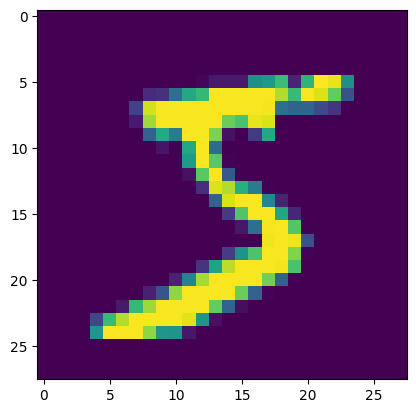

In [ ]:
plt.imshow(numpy_img);

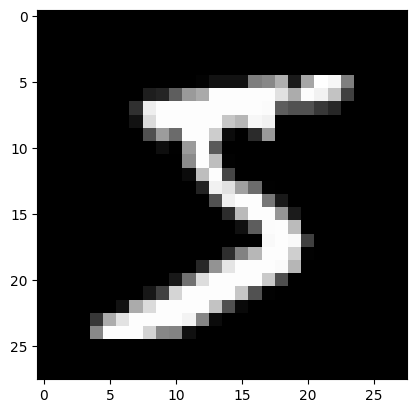

In [ ]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры

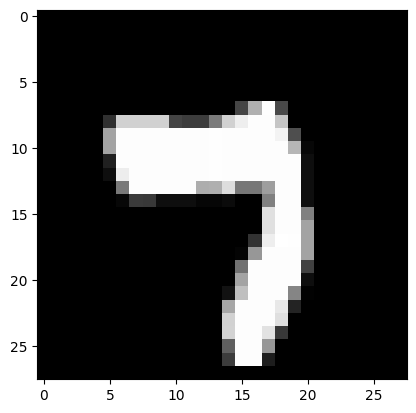

In [ ]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Итерируемся с помощью лоадера:

In [ ]:
for data in trainloader:
    print(data)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

Seuquential парадигма построение нейросети во фреймворке PyTorch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [ ]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Код обучения слоя:

In [ ]:
from tqdm import tqdm

In [ ]:
# объявляем сеть
net = SimpleConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(3)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

 13%|█▎        | 2012/15000 [00:18<01:24, 154.16it/s]

[1,  2000] loss: 0.999



 27%|██▋       | 4016/15000 [00:33<01:14, 148.11it/s]

[1,  4000] loss: 0.419



 40%|████      | 6024/15000 [00:49<00:59, 151.82it/s]

[1,  6000] loss: 0.321



 53%|█████▎    | 8016/15000 [01:04<00:48, 143.89it/s]

[1,  8000] loss: 0.250



 67%|██████▋   | 10025/15000 [01:22<00:43, 115.27it/s]

[1, 10000] loss: 0.217



 80%|████████  | 12027/15000 [01:39<00:21, 140.40it/s]

[1, 12000] loss: 0.195



 93%|█████████▎| 14018/15000 [01:56<00:07, 130.18it/s]

[1, 14000] loss: 0.168



 13%|█▎        | 2022/15000 [00:17<01:36, 133.91it/s]

[2,  2000] loss: 0.151



 27%|██▋       | 4027/15000 [00:34<01:18, 139.28it/s]

[2,  4000] loss: 0.140



 40%|████      | 6026/15000 [00:50<01:07, 132.11it/s]

[2,  6000] loss: 0.135



 54%|█████▎    | 8027/15000 [01:07<00:50, 137.64it/s]

[2,  8000] loss: 0.119



 67%|██████▋   | 10011/15000 [01:26<01:06, 75.04it/s]

[2, 10000] loss: 0.113



 80%|████████  | 12021/15000 [01:43<00:23, 129.00it/s]

[2, 12000] loss: 0.105



 93%|█████████▎| 14024/15000 [01:59<00:07, 123.57it/s]

[2, 14000] loss: 0.106



 13%|█▎        | 2016/15000 [00:17<01:37, 133.06it/s]

[3,  2000] loss: 0.092



 27%|██▋       | 4013/15000 [00:35<01:21, 134.61it/s]

[3,  4000] loss: 0.091



 40%|████      | 6018/15000 [00:52<01:34, 95.08it/s]

[3,  6000] loss: 0.090



 53%|█████▎    | 8012/15000 [01:10<01:16, 90.79it/s]

[3,  8000] loss: 0.085



 67%|██████▋   | 10010/15000 [01:27<00:58, 85.86it/s]

[3, 10000] loss: 0.090



 80%|████████  | 12012/15000 [01:45<00:35, 84.35it/s]

[3, 12000] loss: 0.077



 93%|█████████▎| 14009/15000 [02:03<00:11, 87.65it/s]

[3, 14000] loss: 0.079



100%|██████████| 3/3 [06:25<00:00, 128.40s/it]

Обучение закончено


Тестируем метрику accuracy на тестовом датасете

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 98 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 97 %
Accuracy of     6 : 97 %
Accuracy of     7 : 98 %
Accuracy of     8 : 95 %
Accuracy of     9 : 94 %


### Задача 1.

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [ ]:
def predict_on_test_example(idx):

    img, label = testset[idx]
    plt.imshow(img.squeeze().numpy())
    y_pred = net(img.unsqueeze(dim=0))
    _, predicted = torch.max(y_pred, 1)
    print(f'Модель предсказала класс {predicted.item()}')

Модель предсказала класс 9


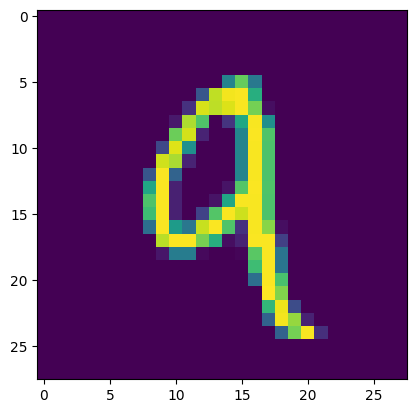

In [ ]:
predict_on_test_example(125)

## CIFAR10

CIFAR10: это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='D:/nvb/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='D:/nvb/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:09<00:00, 17573927.20it/s]


Extracting D:/nvb/data/cifar-10-python.tar.gz to D:/nvb/data
Files already downloaded and verified


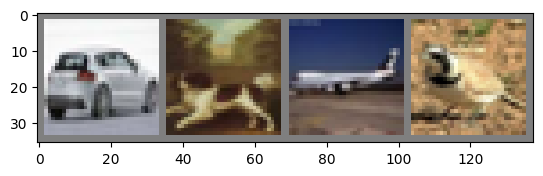

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Функция, которая показывает изображения
def imshow(img):
    img = img / 2 + 0.5     # деномрировка
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# достаем случайные картинки из обучающей выборки
dataiter = iter(trainloader)
images, labels = next(dataiter)

# вызываем функцию, реализующую демонстрацию изображений
imshow(torchvision.utils.make_grid(images))


In [ ]:
# Свёрточная нейросеть для предсказания на CIFAR10.
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(MyConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 765, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.unsqueeze(dim=1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 765)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [ ]:
# пример взят из официального туториала:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # РАЗВОРАЧИВАЕМ КАРТИНКУ В СТРОКУ
        X_batch = X_batch.view(4, -1)

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

 16%|█▌        | 2002/12500 [01:16<09:14, 18.93it/s]

[1,  2000] loss: 1.954



 32%|███▏      | 4002/12500 [02:41<07:00, 20.20it/s]

[1,  4000] loss: 1.709



 48%|████▊     | 6003/12500 [04:05<04:11, 25.87it/s]

[1,  6000] loss: 1.613



 64%|██████▍   | 8001/12500 [05:30<03:43, 20.17it/s]

[1,  8000] loss: 1.574



 80%|████████  | 10003/12500 [06:57<01:35, 26.15it/s]

[1, 10000] loss: 1.520



 96%|█████████▌| 12002/12500 [08:25<00:22, 21.78it/s]

[1, 12000] loss: 1.473



 16%|█▌        | 2005/12500 [01:32<07:03, 24.78it/s]

[2,  2000] loss: 1.430



 32%|███▏      | 4002/12500 [03:01<07:26, 19.02it/s]

[2,  4000] loss: 1.385



 48%|████▊     | 6003/12500 [04:32<04:29, 24.15it/s]

[2,  6000] loss: 1.377



 64%|██████▍   | 8003/12500 [06:04<03:50, 19.52it/s]

[2,  8000] loss: 1.377



 80%|████████  | 10003/12500 [07:37<01:52, 22.18it/s]

[2, 10000] loss: 1.359



 96%|█████████▌| 12002/12500 [09:09<00:29, 17.06it/s]

[2, 12000] loss: 1.342



 16%|█▌        | 2004/12500 [01:36<07:15, 24.08it/s]

[3,  2000] loss: 1.278



 32%|███▏      | 4003/12500 [03:14<08:11, 17.28it/s]

[3,  4000] loss: 1.283



 48%|████▊     | 6002/12500 [04:52<06:30, 16.64it/s]

[3,  6000] loss: 1.257



 64%|██████▍   | 8002/12500 [06:31<04:29, 16.72it/s]

[3,  8000] loss: 1.265



 80%|████████  | 10003/12500 [08:11<02:22, 17.53it/s]

[3, 10000] loss: 1.242



 96%|█████████▌| 12002/12500 [09:54<00:26, 18.93it/s]

[3, 12000] loss: 1.240



 16%|█▌        | 2003/12500 [01:46<10:22, 16.85it/s]

[4,  2000] loss: 1.185



 32%|███▏      | 4003/12500 [03:31<08:53, 15.93it/s]

[4,  4000] loss: 1.185



 48%|████▊     | 6002/12500 [05:18<06:49, 15.87it/s]

[4,  6000] loss: 1.169



 64%|██████▍   | 8003/12500 [07:07<04:02, 18.54it/s]

[4,  8000] loss: 1.181



 80%|████████  | 10003/12500 [09:00<02:12, 18.85it/s]

[4, 10000] loss: 1.174



 96%|█████████▌| 12001/12500 [11:02<00:34, 14.51it/s]

[4, 12000] loss: 1.177



 16%|█▌        | 2003/12500 [02:06<10:39, 16.42it/s]

[5,  2000] loss: 1.107



 32%|███▏      | 4003/12500 [04:15<08:49, 16.05it/s]

[5,  4000] loss: 1.104



 48%|████▊     | 6003/12500 [06:27<06:29, 16.67it/s]

[5,  6000] loss: 1.097



 64%|██████▍   | 8003/12500 [08:39<04:33, 16.41it/s]

[5,  8000] loss: 1.090



 80%|████████  | 10001/12500 [10:56<02:57, 14.05it/s]

[5, 10000] loss: 1.114



 91%|█████████ | 11377/12500 [12:30<01:14, 15.14it/s]

выводим метрики:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 54 %
Accuracy of  bird : 45 %
Accuracy of   cat : 32 %
Accuracy of  deer : 42 %
Accuracy of   dog : 39 %
Accuracy of  frog : 69 %
Accuracy of horse : 79 %
Accuracy of  ship : 71 %
Accuracy of truck : 71 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.5651999999999999

## Задача 3

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [ ]:
# # ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
# class MyConvNet3(nn.Module):
#     def __init__(self):
#         # вызов конструктора предка
#         super(MyConvNet3, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

#         self.pool =  nn.MaxPool2d(kernel_size=2, stride=2)
#         self.norm128 = nn.BatchNorm2d(128)
#         self.norm32 = nn.BatchNorm2d(32)
#         self.dropout2d = nn.Dropout2d(p=0.05)
#         self.dropout = nn.Dropout(p=0.1)

#         self.fc1 = nn.Linear(128 * 2 * 2, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 10)


#     def forward(self, x):

#         x = self.pool(F.relu(self.norm32(self.conv1(x))))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.norm128(self.conv3(x))))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = x.view(-1, 128 * 2 * 2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

1) Уменьшено количество сверточных слоев:
В исходной модели было 4 сверточных слоя (conv1, conv2, conv3, conv4), в упрощенной версии их стало 2 (conv1, conv2).
2) Уменьшено количество фильтров в сверточных слоях
3) Удалены слои DropOut
4) Изменены полносвязные слои
5) Forward метод упрощен

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimplifiedConvNet(nn.Module):
    def __init__(self):
        super(SimplifiedConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.norm32 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # Assuming input image size is 32x32
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.norm32(self.conv2(x))))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


self.conv1 и self.conv2: Эти переменные представляют собой сверточные слои. Сверточный слой применяет операцию свертки к входному изображению, что помогает извлекать пространственные и иерархические особенности из изображения.

self.pool: Это переменная представляет собой слой пулинга, обычно используется для уменьшения размерности (downsampling) изображения, что уменьшает количество параметров и вычислений в сети.

self.norm32: Это переменная представляет собой слой нормализации, который нормализует выходные данные предыдущего слоя по пакетам, что помогает стабилизировать и ускорить обучение.

self.fc1 и self.fc2: Эти переменные представляют собой полносвязные (линейные) слои. Полносвязный слой соединяет каждый нейрон из предыдущего слоя с каждым нейроном текущего слоя.

В методе forward эти слои последовательно применяются к входным данным, чтобы получить итоговый выход (предсказание модели).

In [ ]:
net = SimplifiedConvNet()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(5)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

 16%|█▌        | 2010/12500 [00:29<02:18, 75.87it/s]

[1,  2000] loss: 1.722



 32%|███▏      | 4007/12500 [00:57<02:00, 70.68it/s]

[1,  4000] loss: 1.440



 48%|████▊     | 6012/12500 [01:27<01:25, 75.84it/s]

[1,  6000] loss: 1.328



 64%|██████▍   | 8012/12500 [01:57<01:00, 73.70it/s]

[1,  8000] loss: 1.276



 80%|████████  | 10015/12500 [02:25<00:32, 77.30it/s]

[1, 10000] loss: 1.195



 96%|█████████▌| 12010/12500 [02:55<00:06, 75.05it/s]

[1, 12000] loss: 1.158



 16%|█▌        | 2008/12500 [00:30<02:16, 76.87it/s]

[2,  2000] loss: 1.098



 32%|███▏      | 4011/12500 [01:03<01:55, 73.80it/s]

[2,  4000] loss: 1.052



 48%|████▊     | 6006/12500 [01:34<02:00, 53.95it/s]

[2,  6000] loss: 1.044



 64%|██████▍   | 8014/12500 [02:06<01:00, 74.58it/s]

[2,  8000] loss: 1.013



 80%|████████  | 10015/12500 [02:39<00:34, 72.66it/s]

[2, 10000] loss: 1.017



 96%|█████████▌| 12007/12500 [03:11<00:09, 49.37it/s]

[2, 12000] loss: 1.018



 16%|█▌        | 2007/12500 [00:33<03:42, 47.16it/s]

[3,  2000] loss: 0.929



 32%|███▏      | 4011/12500 [01:03<01:53, 74.50it/s]

[3,  4000] loss: 0.932



 48%|████▊     | 6007/12500 [01:36<01:59, 54.28it/s]

[3,  6000] loss: 0.903



 64%|██████▍   | 8010/12500 [02:10<01:28, 50.68it/s]

[3,  8000] loss: 0.931



 80%|████████  | 10005/12500 [02:41<00:41, 59.73it/s]

[3, 10000] loss: 0.893



 96%|█████████▌| 12008/12500 [03:15<00:07, 66.98it/s]

[3, 12000] loss: 0.925



 16%|█▌        | 2009/12500 [00:34<02:34, 68.00it/s]

[4,  2000] loss: 0.847



 32%|███▏      | 4009/12500 [01:09<02:43, 51.81it/s]

[4,  4000] loss: 0.862



 48%|████▊     | 6014/12500 [01:42<01:33, 69.52it/s]

[4,  6000] loss: 0.836



 64%|██████▍   | 8009/12500 [02:17<01:31, 49.30it/s]

[4,  8000] loss: 0.844



 80%|████████  | 10007/12500 [02:50<00:44, 56.49it/s]

[4, 10000] loss: 0.828



 96%|█████████▌| 12010/12500 [03:24<00:06, 70.14it/s]

[4, 12000] loss: 0.845



 16%|█▌        | 2007/12500 [00:34<02:40, 65.38it/s]

[5,  2000] loss: 0.758



 32%|███▏      | 4011/12500 [01:12<02:26, 58.04it/s]

[5,  4000] loss: 0.781



 45%|████▌     | 5670/12500 [01:41<01:48, 62.94it/s]

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 76 %
Accuracy of  bird : 59 %
Accuracy of   cat : 47 %
Accuracy of  deer : 64 %
Accuracy of   dog : 53 %
Accuracy of  frog : 81 %
Accuracy of horse : 78 %
Accuracy of  ship : 76 %
Accuracy of truck : 84 %


In [ ]:
mean_accuracy = np.mean([class_correct[i] / class_total[i] for i in range(10)])
mean_accuracy

0.6912

Получилось улучшить в среднем показатели по каждому классу с 0.56 до 0.69, при этом упростив модель (см.выше) и ускорив процесс обучения